## Necessary Imports

In [1]:
%matplotlib notebook
import pandas as pd, numpy as np, random
import matplotlib.pyplot as plt, matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns

## Reading Data

We have 6 difference species worth of data. Here we are reading in and analyzing just one. 

In [2]:
# Read csv into data frame. 
df = pd.read_csv('data/gene_level/DC10_GL_clust-smry.csv')

# Keep only relevant columns in the data frame.
df = df[['sum_meanTPM_Ti','sum_meanTPM_Tii','sum_meanTPM_Tiii','sum_meanTPM_Tiv', 'TC_qval']]

# Remove rows that have missing values and/or infinite values. 
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Convert everything to doubles. 
df = df.astype('double')

# Remove rows with TC_qval greater than 0.1. These are 'Timecourse Corrected P-Values' that are based on variance.
# The lower the q value, the tigher the spread. 
df = df[df['TC_qval'] < 0.1]

# We are not done with the q values. So we remove them.
df = df.drop(['TC_qval'], axis = 1)

## Raw Data Plot

Each gene has expression levels given at 4 different time points. We take each one of those time points and plot them. Since we can only plot in 3 dimensions, the last time point is represented as color. 

<IPython.core.display.Javascript object>


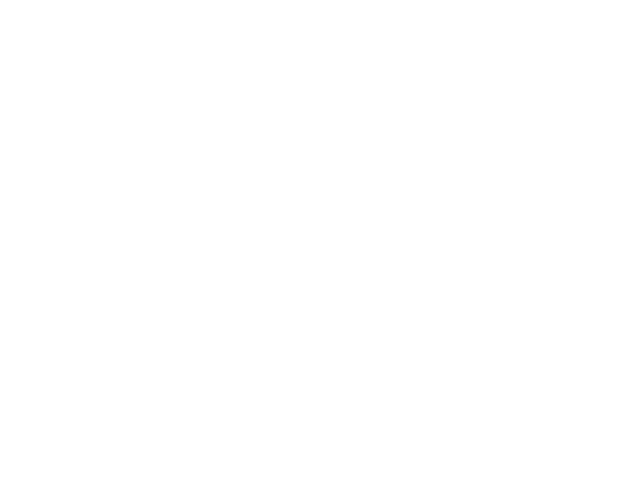

In [3]:
# Most of the data points are less than 200. I am only plotting ones larger than 200 to make the code run faster.
x = df['sum_meanTPM_Ti'].where(df['sum_meanTPM_Ti'] > 100)
y = df['sum_meanTPM_Tii'].where(df['sum_meanTPM_Tii'] > 100)
z = df['sum_meanTPM_Tiii'].where(df['sum_meanTPM_Tiii'] > 100)
r = df['sum_meanTPM_Tiv'].where(df['sum_meanTPM_Tiv'] > 100)

# Supress massive values by taking log. 
# Values may be massive becuase of large expression levels or misreads. 
x = np.log10(x)
y = np.log10(y)
z = np.log10(z)
r = np.log10(r)

# Plot the result. 
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=r, cmap='viridis', linewidth=0.5);
ax.set_xlabel('sum_meanTPM_Ti')
ax.set_ylabel('sum_meanTPM_Tii')
ax.set_zlabel('sum_meanTPM_Tiii')
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

## Clustering

Discounting color we can see 3 distinct bands. Each one of these represents a group of genes with similar expression curves. 

These bands do not follow the good clustering principal. So it is very difficult to tease them appart. Especially when we consider the 4th dimension (color). 

So we use singular vector decomposition to reduce the dimensionality and create groups that follow the good clustering principal. 

In [4]:
# We normalize the data with 'l2' normalization.
# This makes the sum of the squares of each feature equal to one.
normalized_df = preprocessing.normalize(df, norm = 'l2')

# Create a object that can perform the singular vector decomposition
svd = TruncatedSVD(n_components=3)

# We perform the singular vector decomposition.
# This results in a 3 dimensional data set.
reduced = svd.fit_transform(normalized_df)

# Converting the result to a dataframe.
reduced_df = pd.DataFrame(data=reduced, columns = ["x", "y", "z"])

# My man Kartik Krishnan says that 8 clusters are where its at.
pred = KMeans(n_clusters = 8).fit_predict(reduced_df)

# Lets plot it. We color based off the color. 
x = reduced_df["x"]
y = reduced_df["y"]
z = reduced_df["z"]
r = pred

ax = plt.axes(projection='3d') 
ax.scatter(x, y, z, c=r, cmap='viridis', linewidth=0.5);
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

## Contents of each cluster. 

Each one of these clusters should represent genes that follow similar expression curves. We should check to make sure that is the case.

In [5]:
# We gotta tidy up our dataframe to make these plots work. 
# This will take a hot second to run. Its cool. Grab some coffee or something. 

df['cluster'] = pred

tidy_df = pd.DataFrame(columns=['tp','cluster','mean_TPM'])

for index, row in df.iterrows():
    
    # Normalize each gene. We only care about the shape.
    mean_TPMs = row[0:4]
    mean_TPMs = (mean_TPMs - mean_TPMs.min()) / (mean_TPMs.max() - mean_TPMs.min())    
    
    # Append genes info to tidy_df
    tidy_df = tidy_df.append({ 'tp':0, 'cluster':row[4], 'mean_TPM':mean_TPMs[0]}, ignore_index = True)
    tidy_df = tidy_df.append({ 'tp':1, 'cluster':row[4], 'mean_TPM':mean_TPMs[1]}, ignore_index = True)
    tidy_df = tidy_df.append({ 'tp':2, 'cluster':row[4], 'mean_TPM':mean_TPMs[2]}, ignore_index = True)
    tidy_df = tidy_df.append({ 'tp':3, 'cluster':row[4], 'mean_TPM':mean_TPMs[3]}, ignore_index = True)
    
tidy_df

,tp,cluster,mean_TPM
0,0.0,3.0,0.551728
1,1.0,3.0,0.000000
2,2.0,3.0,0.306875
3,3.0,3.0,1.000000
4,0.0,3.0,0.109753
...,...,...,...
24819,3.0,3.0,0.187216
24820,0.0,3.0,0.721410
24821,1.0,3.0,0.000000
24822,2.0,3.0,0.342651


<IPython.core.display.Javascript object>


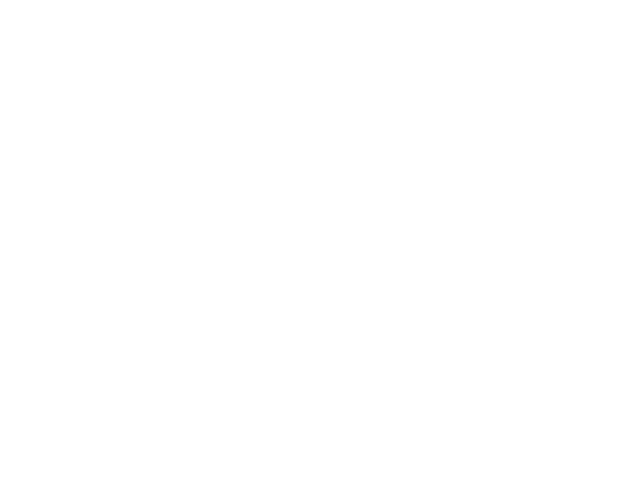

<IPython.core.display.Javascript object>


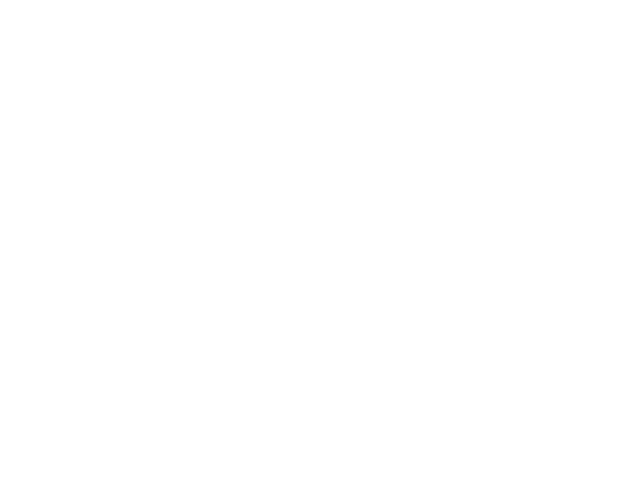

<IPython.core.display.Javascript object>


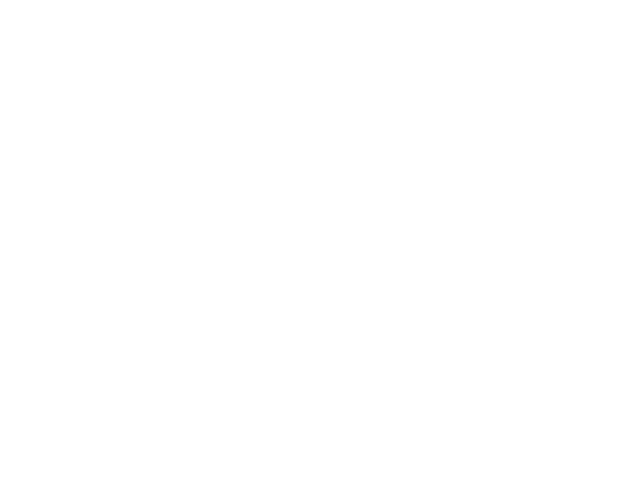

<IPython.core.display.Javascript object>


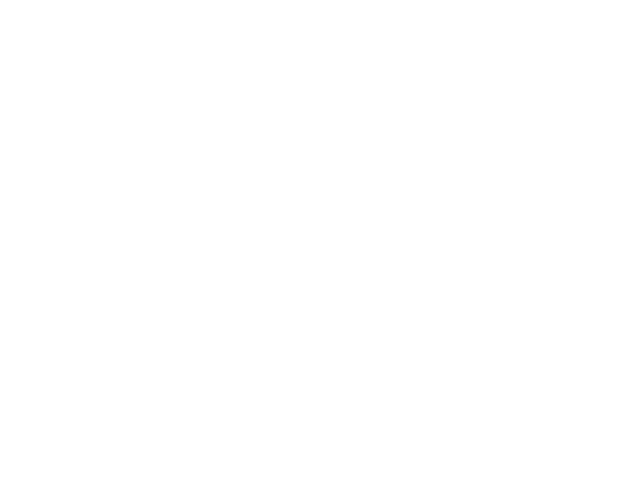

<IPython.core.display.Javascript object>


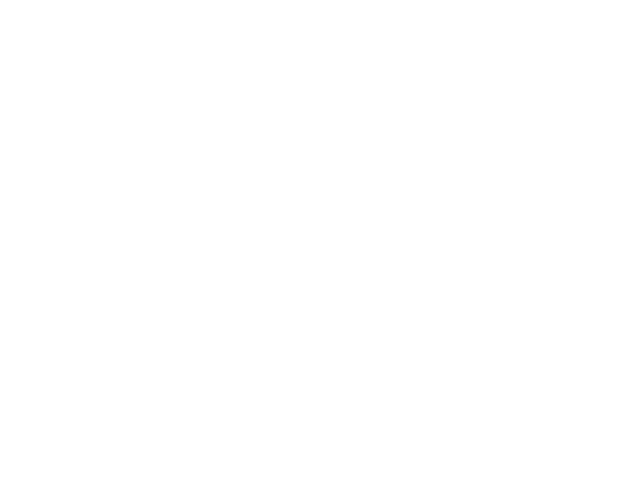

<IPython.core.display.Javascript object>


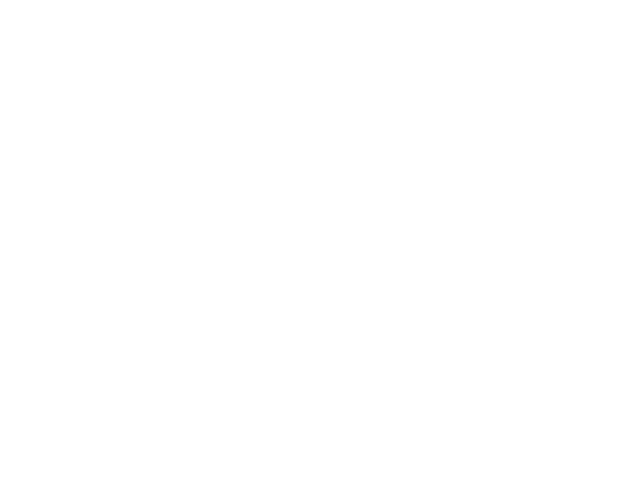

<IPython.core.display.Javascript object>


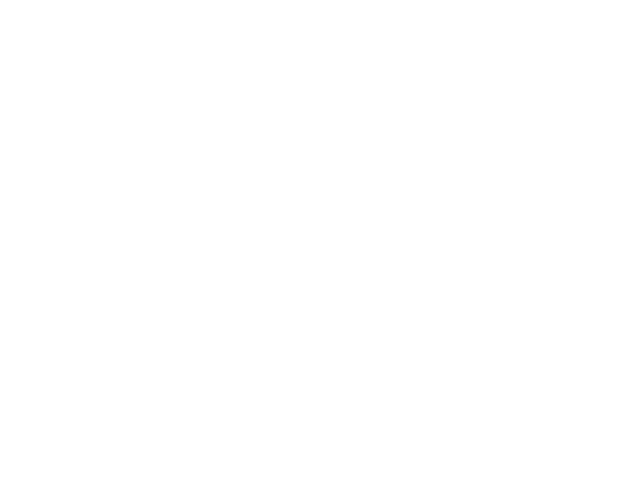

<IPython.core.display.Javascript object>


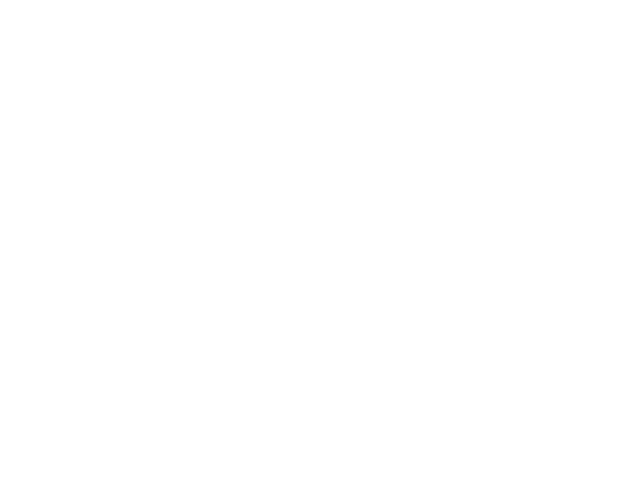

In [6]:
# Plot each clusters genes.
%matplotlib notebook

for i in range(8):
    plt.figure()
    cluster_df = tidy_df[tidy_df.cluster == i]
    ax = sns.lineplot(x="tp", y="mean_TPM", data=cluster_df, ci='sd')
    ax.set_title('Cluster ' + str(i) + '. Contains ' + str(int(cluster_df.shape[0]/4)) + ' genes.')
    ax.set_xticks([0,1,2,3])

<IPython.core.display.Javascript object>


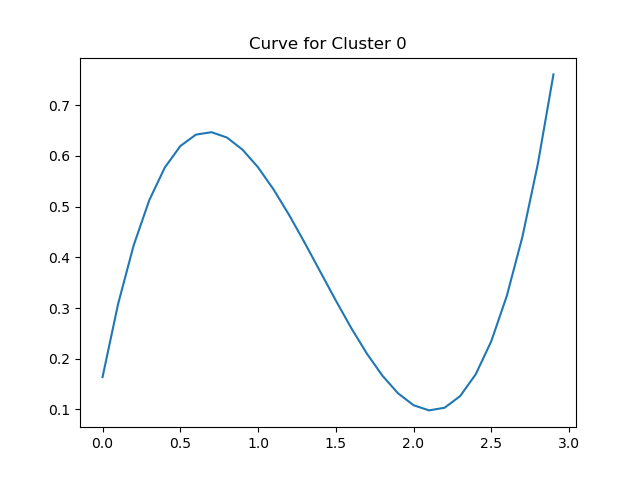

<IPython.core.display.Javascript object>


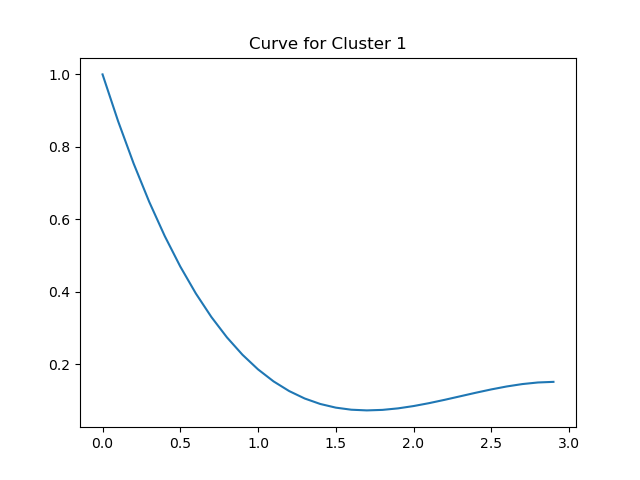

<IPython.core.display.Javascript object>


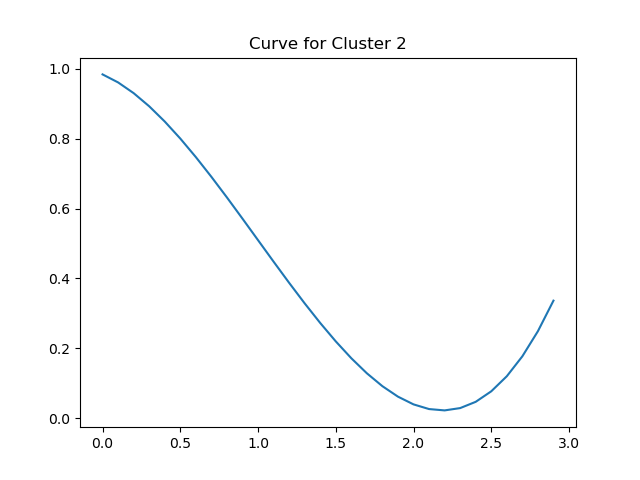

<IPython.core.display.Javascript object>


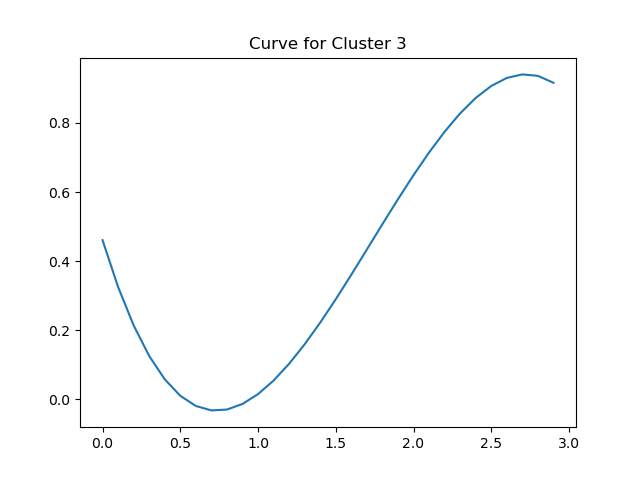

<IPython.core.display.Javascript object>


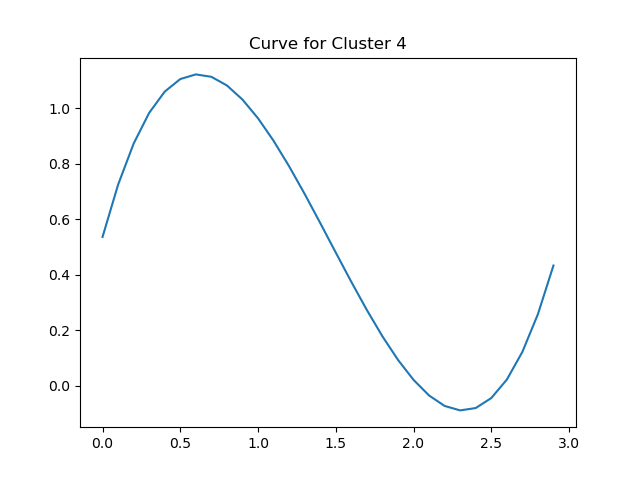

<IPython.core.display.Javascript object>


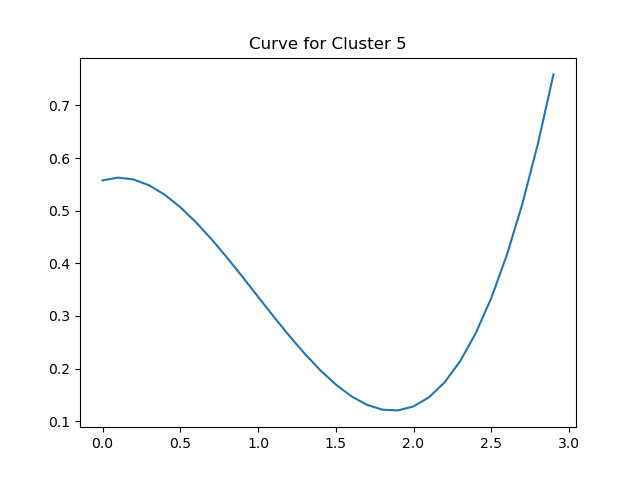

<IPython.core.display.Javascript object>


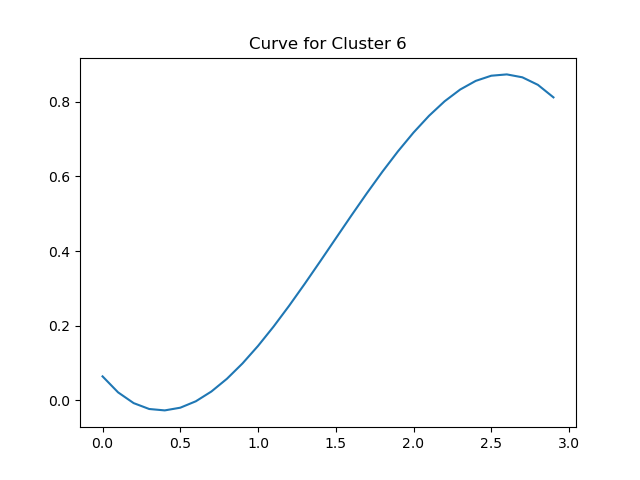

<IPython.core.display.Javascript object>


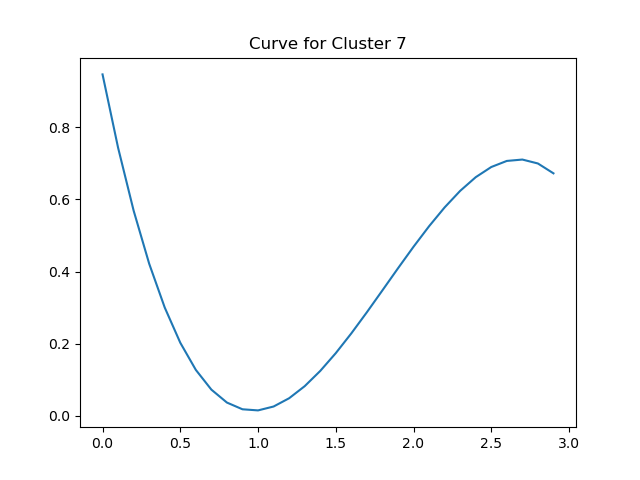

In [7]:
%matplotlib notebook
import scipy.optimize
import matplotlib.pyplot as plt


#parameter for curve_fit that provides general structure of curve
def func_struct(x, a, b, c, d):
    return a*(x**3)+b*(x**2)+c*(x)+d


#creates datapoints from 0 to 3 at intervals of 0.1
time = np.arange(0.0, 3.0, 0.1)

functions = {}

for i in range(8):
    plt.figure()
    cluster_df = tidy_df[tidy_df.cluster == i]
    popt, pcov = scipy.optimize.curve_fit(func_struct, cluster_df.tp, cluster_df.mean_TPM)
    functions[i] = popt
       
    
    plt.title("Curve for Cluster " + str(i))
    plt.plot(time, func_struct(time, popt[0], popt[1], popt[2], popt[3]))
    plt.show()
   
    
    

In [8]:
functions

{0: array([ 0.36908352, -1.54887446,  1.59368135,  0.1637315 ]),
 1: array([-0.0910777 ,  0.62973384, -1.35292929,  0.99982661]),
 2: array([ 0.14434582, -0.43082983, -0.18773812,  0.98388686]),
 3: array([-0.24703265,  1.28040555, -1.47862992,  0.46072087]),
 4: array([ 0.48995059, -2.15429439,  2.09147562,  0.5362285 ]),
 5: array([ 0.16282817, -0.4822452 ,  0.09851717,  0.55758062]),
 6: array([-0.16913688,  0.75231184, -0.50162349,  0.06446109]),
 7: array([-0.28051284,  1.5351228 , -2.18745354,  0.94721798])}

In [72]:
import numpy as np
import similaritymeasures
import matplotlib.pyplot as plt
from numpy import *
from matplotlib.pyplot import *


time = np.arange(0.0, 3.0, 0.1)

datapoint_arrays = []

#create data 
# there are 8 clusters to get data from
for i in range(0, 8):
    #each time interval
    for j in range(0, len(time)):
        y[j] = func_struct(time[j], functions[i][0], functions[i][1], functions[i][2], functions[i][3])
    #add the array made up datapoints for this cluster
    arr = np.zeros((len(time), 2))
    arr[:, 0] = time
    arr[:, 1] = y
    datapoint_arrays.append(arr)

    

def run_comparisons(c1, c2):
    # quantify the difference between the two curves using PCM
    pcm = similaritymeasures.pcm(datapoint_arrays[c1], datapoint_arrays[c2])
    pcm_matrix[c1][c2] = pcm
    
    # quantify the difference between the two curves using
    # Discrete Frechet distance
    df = similaritymeasures.frechet_dist(datapoint_arrays[c1], datapoint_arrays[c2])
    frechet_matrix[c1][c2] = df

    # quantify the difference between the two curves using
    # area between two curves
    area = similaritymeasures.area_between_two_curves(datapoint_arrays[c1], datapoint_arrays[c2])
    area_matrix[c1][c2] = area
    # quantify the difference between the two curves using
    # Curve Length based similarity measure
    cl = similaritymeasures.curve_length_measure(datapoint_arrays[c1], datapoint_arrays[c2])
    cl_matrix[c1][c2] = cl
    
    # quantify the difference between the two curves using
    # Dynamic Time Warping distance
    dtw, d = similaritymeasures.dtw(datapoint_arrays[c1], datapoint_arrays[c2])
    dtw_matrix[c1][c2] = dtw
    

#converting to easily viewable 2d arrays

w, h = 8, 8;
frechet_matrix = [[0 for x in range(w)] for y in range(h)] 
pcm_matrix = [[0 for x in range(w)] for y in range(h)] 
area_matrix = [[0 for x in range(w)] for y in range(h)] 
cl_matrix = [[0 for x in range(w)] for y in range(h)] 
dtw_matrix = [[0 for x in range(w)] for y in range(h)] 


for i in range(0, 8):
    for j in range(i + 1, 8):
        run_comparisons(i, j)


def print_matrix(title, matrix):
    print('\n'+title)
    print(' '.join(["{:8}".format(x) for x in range(0, 8)]))          
    for i in range(0, 8):
        print ('\n'+str(i)+' '+' '.join(["{:8.5f}".format(matrix[i][j]) for j in range(0, 8)]))
        

print_matrix('PCM', pcm_matrix)
print_matrix('Frechet Distance', frechet_matrix)
print_matrix('Area Difference', area_matrix)
print_matrix('Curve Length Distance', cl_matrix)
print_matrix('Dynamic Time Warping Distance', dtw_matrix)
  




PCM
       0        1        2        3        4        5        6        7

0  0.00000  4.31685  3.14631  7.19325  3.58891  3.87773  7.55944  4.36232

1  0.00000  0.00000  1.55649  8.91928  3.98830  2.29383  9.44572  6.29610

2  0.00000  0.00000  0.00000  7.78867  2.55477  1.76183  8.46773  6.09357

3  0.00000  0.00000  0.00000  0.00000 10.01494  4.18086  1.98738  4.71906

4  0.00000  0.00000  0.00000  0.00000  0.00000  6.10615  8.09264  5.99056

5  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  4.76618  4.72888

6  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  6.05702

7  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000

Frechet Distance
       0        1        2        3        4        5        6        7

0  0.00000  0.83610  0.82016  0.67546  0.47933  0.39385  0.66466  0.78349

1  0.00000  0.00000  0.31323  0.79524  0.69492  0.60772  0.93537  0.56855

2  0.00000  0.00000  0.00000  0.76672  0.44766  0.42631  0.91943  0.58206

3  0.00